# Sweeping Parameters

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [7]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [8]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [9]:
# import functions from modsim

from modsim import *

In [10]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/chap11.py')

In [11]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/chap12.py')

In [15]:
# import code from previous notebooks

from chap11 import make_system
from chap11 import update_func
from chap11 import run_simulation
from chap11 import plot_results

from chap12 import calc_total_infected

In the previous chapter we extended the Kermack-McKendrick (KM) model to include immunization and used it to demonstrate herd immunity.

But we assumed that the parameters of the model, contact rate and
recovery rate, were known. In this chapter, we'll explore the behavior of
the model as we vary these parameters.

In the next chapter, we'll use analysis to understand these relationships better, and propose a method for using data to estimate parameters.

## Sweeping Beta

Recall that $\beta$ is the contact rate, which captures both the
frequency of interaction between people and the fraction of those
interactions that result in a new infection. If $N$ is the size of the
population and $s$ is the fraction that's susceptible, $s N$ is the
number of susceptibles, $\beta s N$ is the number of contacts per day
between susceptibles and other people, and $\beta s i N$ is the number
of those contacts where the other person is infectious.

As $\beta$ increases, we expect the total number of infections to
increase. To quantify that relationship, I'll create a range of values
for $\beta$:

In [16]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

We'll start with a single value for `gamma`, which is the recovery rate, that is, the fraction of infected people who recover per day.

The following function takes `beta_array` and `gamma` as parameters.
It runs the simulation for each value of `beta` and computes the same metric we used in the previous chapter, the fraction of the population that gets infected.

The result is a `SweepSeries` that contains the values of `beta` and the corresponding metrics.

In [17]:
def sweep_beta(beta_array, gamma):
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

We can run `sweep_beta` like this:

In [18]:
infected_sweep = sweep_beta(beta_array, gamma)

Before we plot the results, I will use a formatted string literal, also called an *f-string* to assemble a label that includes the value of `gamma`:

In [19]:
label = f'gamma = {gamma}'
label

'gamma = 0.25'

An f-string starts with the letter `f` followed by a string in single or double quotes. 
The string can contain any number of format specifiers in squiggly brackets, `{}`.
When a variable name appears in a format specifier, it is replaced with the value of the variable.

In this example, the value of `gamma` is `0.25`, so the value of `label` is `'gamma = 0.25'`.

You can read more about f-strings at <https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings>.

Now let's see the results.

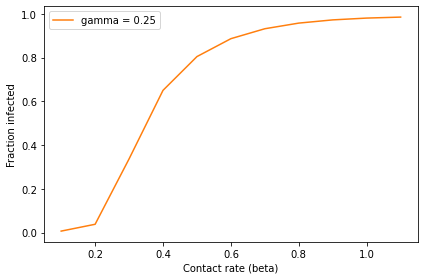

In [20]:
infected_sweep.plot(label=label, color='C1')

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

Remember that this figure
is a parameter sweep, not a time series, so the x-axis is the parameter
`beta`, not time.

When `beta` is small, the contact rate is low and the outbreak never
really takes off; the total number of infected students is near zero. As
`beta` increases, it reaches a threshold near 0.3 where the fraction of
infected students increases quickly. When `beta` exceeds 0.5, more than
80% of the population gets sick.

## Sweeping Gamma

Let's see what that looks like for a few different values of `gamma`.
We'll use `linspace` to make an array of values:

In [21]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

array([0.1, 0.3, 0.5, 0.7])

And run `sweep_beta` for each value of `gamma`:

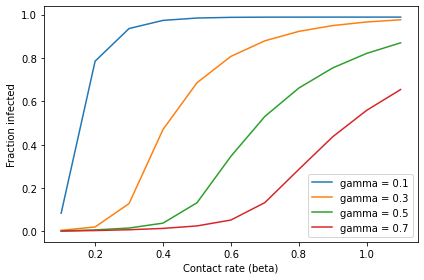

In [22]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = f'gamma = {gamma}'
    infected_sweep.plot(label=label)
    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

When `gamma` is low, the recovery rate is low, which means people are infectious longer.
In that case, even a low contact rate (`beta`) results in an epidemic.

When `gamma` is high, `beta` has to be even higher to get things going.

## Using a SweepFrame

In the previous section, we swept a range of values for `gamma`, and for
each value of `gamma`, we swept a range of values for `beta`. This process is a
*two-dimensional sweep*.

If we want to store the results, rather than plot them, we can use a
`SweepFrame`, which is a kind of `DataFrame` where the rows sweep one
parameter, the columns sweep another parameter, and the values contain
metrics from a simulation.

This function shows how it works:

In [23]:
def sweep_parameters(beta_array, gamma_array):
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

`sweep_parameters` takes as parameters an array of values for `beta` and
an array of values for `gamma`.

It creates a `SweepFrame` to store the results, with one column for each
value of `gamma` and one row for each value of `beta`.

Each time through the loop, we run `sweep_beta`. The result is a
`SweepSeries` object with one element for each value of `beta`. The
assignment inside the loop stores the `SweepSeries` as a new column in
the `SweepFrame`, corresponding to the current value of `gamma`.

At the end, the `SweepFrame` stores the fraction of students infected
for each pair of parameters, `beta` and `gamma`.

We can run `sweep_parameters` like this:

In [24]:
frame = sweep_parameters(beta_array, gamma_array)

With the results in a `SweepFrame`, we can plot each column like this:

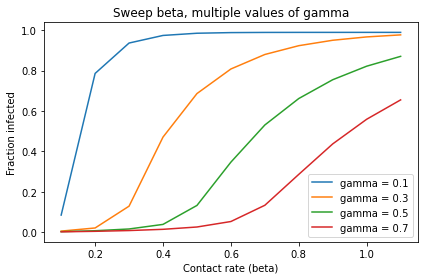

In [25]:
for gamma in gamma_array:
    label = f'gamma = {gamma}'
    frame[gamma].plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         title='Sweep beta, multiple values of gamma')

Alternatively, we can plot each row like this:

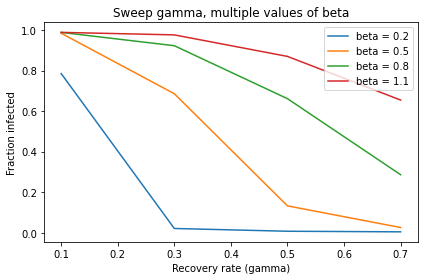

In [26]:
for beta in [0.2, 0.5, 0.8, 1.1]:
    label = f'beta = {beta}'
    frame.loc[beta].plot(label=label)
    
decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected',
         title='Sweep gamma, multiple values of beta')

This example demonstrates one use of a `SweepFrame`: we can run the analysis once, save the results, and then generate different visualizations.

Another way to visualize the results of a two-dimensional sweep is a
*contour plot*, which shows the parameters on the axes and contour
lines where the value of the metric is constant.

The ModSim library provides `contour`, which takes a `SweepFrame` and uses Matplotlib to generate a contour plot.

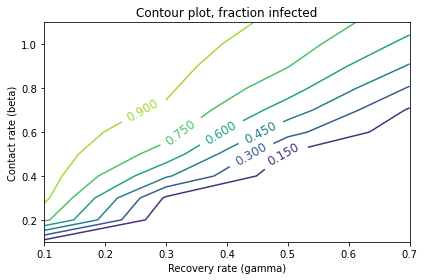

In [27]:
contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Contour plot, fraction infected')

The values of `gamma` are on the $x$-axis, corresponding to the columns of the `SweepFrame`.
The values of `beta` are on the $y$-axis, corresponding to the rows of the `SweepFrame`.

Infection rates are lowest in the lower right, where the contact rate is low and the recovery rate is high. They increase as we move to the upper left, where the contact rate is high and the recovery rate is low.



## Summary

This chapter demonstrates a two-dimensional parameter sweep using a `SweepFrame` to store the results.

We plotted the results three ways: 

* First we plotted total infections versus `beta`, with one line for each value of `gamma`.

* Then we plotted total infections versus `gamma`, with one line for each value of `beta`.

* Finally, we made a contour plot with `beta` on the $y$-axis, `gamma` on the $x$-axis and contour lines where the metric is constant.

These visualizations suggest that there is a relationship between `beta` and `gamma` that determines the outcome of the model. 
In fact, there is.
In the next chapter we'll explore it by running simulations, then derive it by analysis.

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1

  If we know `beta` and `gamma`, we can compute the fraction of the population that gets infected.  In general, we don't know these parameters, but sometimes we can estimate them based on the behavior of an outbreak.

Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts, `1/beta`.

In [28]:
# Solution goes here
# Fixed gamma value
gamma = 1/2

# Beta array
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]

In [29]:
# Solution goes here
# Run the sweep beta function
infected_sweep = sweep_beta(beta_array, gamma)

In [31]:
# Solution goes here
from scipy.interpolate import UnivariateSpline
# Using UnivariateSpline function from the scipy library to estimate beta
x = infected_sweep.index
y = infected_sweep.values
f = UnivariateSpline(y, x, s=0)
estimate_beta = f(0.4)

In [32]:
1/estimate_beta

1.5950622949524849